<a href="https://colab.research.google.com/github/PeterRutkowski/driver_mocap/blob/main/TrainingConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook describes trainig the convolutional network on the dataset containing faces of 28 celebrities, both men and women. The training set has 28 $\times$ 400 images and the test set has 28 $\times$ 100 images. Every image is 250$\times$250 pixels large.

### Mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!tar -xzf /content/drive/MyDrive/Datasets/28celeb_faces.tar.gz -C /content

### Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt

import pickle
from pathlib import Path

PATH_TO_MOCAP = Path("drive/MyDrive/Colab Notebooks/mocap/TrainingConvNetOnCelebFaces")

### Data loaders

In [ ]:
train_path = '/content/dnn2020-1/train/'
train_dataset = torchvision.datasets.ImageFolder(
        root=train_path,
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
)
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=256,
        num_workers=0,
        shuffle=True
    )

test_path = '/content/dnn2020-1/test'
test_dataset = torchvision.datasets.ImageFolder(
        root=test_path,
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=99,
        num_workers=0,
        shuffle=True
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


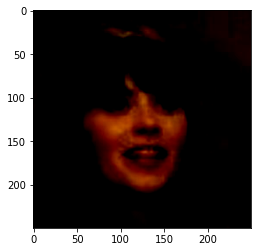

In [ ]:
for sample_data in train_loader:
  break

plt.imshow(sample_data[0][3, ::].permute(1,2,0))

### Training the first network

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, bias = False)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, bias = False)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 7, bias = False)
        self.bn4 = nn.BatchNorm2d(num_features=32)
        
        self.fc1 = nn.Linear(32 * 11 * 11, 1000, bias = False)
        self.bn5 = nn.BatchNorm1d(1000)
        self.fc2 = nn.Linear(1000, 28)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
                
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = x.view(-1, 32*11*11)
        x = self.fc1(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x


net = ConvNet()
print(net)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3872, out_features=1000, bias=False)
  (bn5): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1000, out_features=28, bias=True)
)


In [ ]:
n_epochs = 30
criterion = nn.CrossEntropyLoss()         
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = ConvNet()
net.to(device)
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)

train_loss = []
test_loss = []
test_acc = []

for epoch in range(n_epochs):
    for data in train_loader:  
        inputs, labels = data[0].to(device), data[1].to(device)
  
        optimizer.zero_grad()
  
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
  
        train_loss.append(loss.item())
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss.append(loss.item())     
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc.append(correct/total)

In [ ]:
torch.save(net.state_dict(), PATH_TO_MOCAP / 'model1/ConvNet_weights.pth')

In [ ]:
model_history = {"train_loss" : train_loss,
                 "test_loss" : test_loss,
                 "test_acc" : test_acc}
with open(PATH_TO_MOCAP / "model1/history.pickle", "wb") as f:
  pickle.dump(model_history, f)

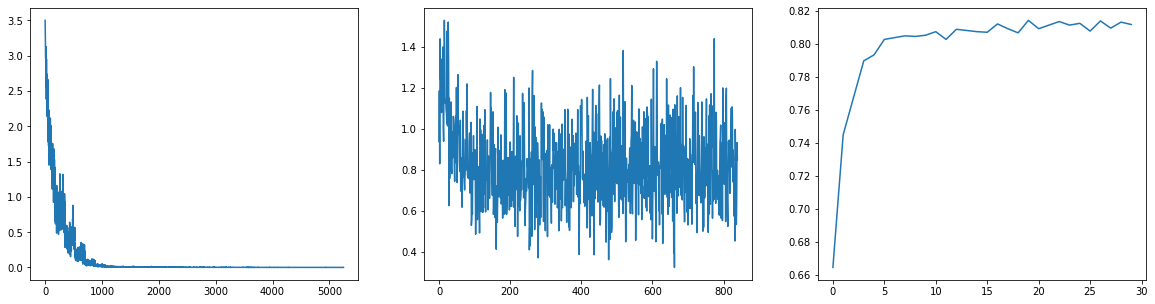

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (20,5))

ax[0].plot(train_loss)

ax[1].plot(test_loss)

ax[2].plot(test_acc)

### Trainig a bigger network
Here I declare a bigger network. I add one more convolutional layer and one more dense layer. I also add dropout layer between dense layers. 

In [ ]:
class BiggerConvNet(nn.Module):
    def __init__(self):
        super(BiggerConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, bias = False)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, bias = False)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 7, bias = False)
        self.bn4 = nn.BatchNorm2d(num_features=32)
        
        self.fc1 = nn.Linear(32 * 11 * 11, 1000, bias = False)
        self.dropout1 = nn.Dropout()
        self.bn6 = nn.BatchNorm1d(1000)
        
        self.fc2 = nn.Linear(1000, 1000)
        self.dropout2 = nn.Dropout()
        self.bn7 = nn.BatchNorm1d(1000)
        
        self.fc3 = nn.Linear(1000,28)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
                
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = x.view(-1, 32*11*11)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.bn6(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.bn7(x)
        x = F.relu(x)

        x = self.fc3(x)
        
        return x

In [ ]:
n_epochs = 30
criterion = nn.CrossEntropyLoss()         
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = BiggerConvNet()
net.to(device)
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)

train_loss = []
test_loss = []
test_acc = []

for epoch in range(n_epochs):
  print(f"Epoch {epoch+1}")
  for data in train_loader:  
    inputs, labels = data[0].to(device), data[1].to(device)
    net.train()
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
  
  correct = 0
  total = 0
  with torch.no_grad():
    net.eval()
    for data in test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = net(images)
      loss = criterion(outputs, labels)
      test_loss.append(loss.item())     
      
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc.append(correct/total)

  print(f"Loss: {train_loss[-1]} | Test loss: {test_loss[-1]} | Test acc: {test_acc[-1]}\n")

Epoch 1
Loss: 1.9362415075302124 | Test loss: 1.9446775913238525 | Test acc: 0.40115440115440115

Epoch 2
Loss: 1.708301067352295 | Test loss: 1.5838096141815186 | Test acc: 0.5281385281385281

Epoch 3
Loss: 1.289732813835144 | Test loss: 1.18440842628479 | Test acc: 0.6637806637806638

Epoch 4
Loss: 1.4103206396102905 | Test loss: 1.184216022491455 | Test acc: 0.6911976911976911

Epoch 5
Loss: 0.9945740103721619 | Test loss: 1.2025001049041748 | Test acc: 0.7366522366522367

Epoch 6
Loss: 0.8414462804794312 | Test loss: 0.8426244854927063 | Test acc: 0.7514430014430015

Epoch 7
Loss: 0.5036876201629639 | Test loss: 0.5638193488121033 | Test acc: 0.7792207792207793

Epoch 8
Loss: 0.5568539500236511 | Test loss: 0.6744686961174011 | Test acc: 0.7875180375180375

Epoch 9
Loss: 0.4003167748451233 | Test loss: 0.49551257491111755 | Test acc: 0.7777777777777778

Epoch 10
Loss: 0.3051353991031647 | Test loss: 0.9065362215042114 | Test acc: 0.8008658008658008

Epoch 11
Loss: 0.252271801233291

It looks as if the bigger network performed nearly the same as the previous one. So maybe increasing number of data via data augmentation is a good idea?

### Training the network with data augmentation

I define new data loader

In [ ]:
train_path = '/content/dnn2020-1/train/'
train_dataset = torchvision.datasets.ImageFolder(
        root=train_path,
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomPerspective(),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.RandomPerspective()]))

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True
    )

test_path = '/content/dnn2020-1/test'
test_dataset = torchvision.datasets.ImageFolder(
        root=test_path,
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=99,
        num_workers=0,
        shuffle=True
    )

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30


Text(0.5, 1.0, 'Test accuracy')

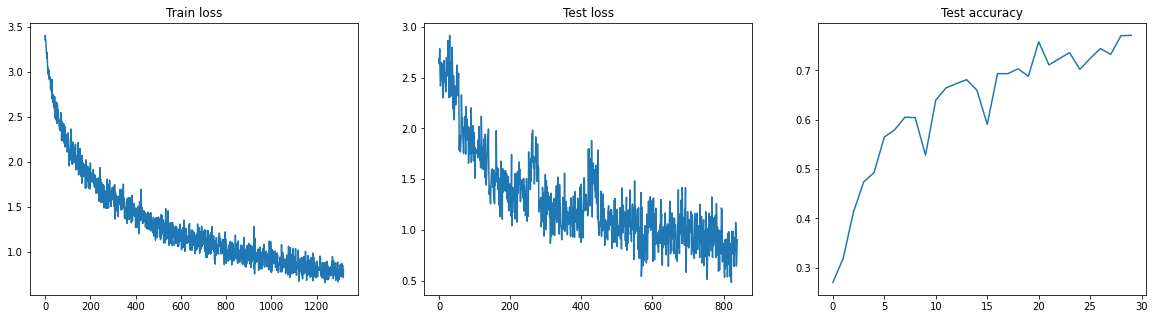

In [ ]:
n_epochs = 30
criterion = nn.CrossEntropyLoss()         
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = ConvNet()
net.to(device)
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)

train_loss = []
test_loss = []
test_acc = []

for epoch in range(n_epochs):
  print(f"Epoch {epoch+1}")
  net.train()
  for data in train_loader:  
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
  
  correct = 0
  total = 0
  with torch.no_grad():
    net.eval()
    for data in test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = net(images)
      loss = criterion(outputs, labels)
      test_loss.append(loss.item())     
      
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc.append(correct/total)

fig, ax = plt.subplots(1,3, figsize = (20,5))

ax[0].plot(train_loss)
ax[0].set_title("Train loss")
ax[1].plot(test_loss)
ax[1].set_title("Test loss")
ax[2].plot(test_acc)
ax[2].set_title("Test accuracy")

After data augmentation the model performs worse. But the plots suggest that the model could be trained longer. The learning rate could be higher, at least at the beginning. I will also try bigger model (taking advantage of having more data).

### Data augmentation, bigger model, longer training

In [ ]:
class BiggerConvNet2(nn.Module):
    def __init__(self):
        super(BiggerConvNet2, self).__init__()
        
        self.cnn_layers = nn.Sequential(
          nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, bias = False),
          nn.BatchNorm2d(num_features=32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          
          nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, bias = False),
          nn.BatchNorm2d(num_features=32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, bias = False),
          nn.BatchNorm2d(num_features=64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, bias = False),
          nn.BatchNorm2d(num_features=128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
          nn.Linear(128 * 13 * 13, 512, bias = False),
          nn.Dropout(),
          nn.BatchNorm1d(512),
          nn.ReLU(),

          nn.Linear(512, 28)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 128 * 13 * 13)
        x = self.linear_layers(x)
        return x

In [ ]:
n_epochs = 50
criterion = nn.CrossEntropyLoss()         
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = BiggerConvNet2()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.01, weight_decay=0.001)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95, last_epoch=-1, verbose=False)

train_loss = []
test_loss = []
test_acc = []

for epoch in range(n_epochs):
  if (epoch + 1) % 5 == 0:
    print(f"Epoch {epoch+1}")
    print(f"Loss: {train_loss[-1]} | Test loss: {test_loss[-1]} | Test acc: {test_acc[-1]}\n")
  
  net.train()
  for data in train_loader:  
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
  
  correct = 0
  total = 0
  with torch.no_grad():
    net.eval()
    for data in test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = net(images)
      loss = criterion(outputs, labels)
      test_loss.append(loss.item())     
      
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc.append(correct/total)

  # scheduler.step()


model_folder_name = PATH_TO_MOCAP / 'model_with_data_aug'
model_folder_name.mkdir(exist_ok = True)

model_history = {"train_loss" : train_loss,
                 "test_loss" : test_loss,
                 "test_acc" : test_acc}

with open(model_folder_name / 'history.pickle', 'wb') as f:
  pickle.dump(model_history, f)


torch.save(net.state_dict(), model_folder_name / 'ConvNet_weights.pth')

fig, ax = plt.subplots(1,3, figsize = (20,5))

ax[0].plot(train_loss)
ax[0].set_title("Train loss")
ax[1].plot(test_loss)
ax[1].set_title("Test loss")
ax[2].plot(test_acc)
ax[2].set_title("Test accuracy")

Epoch 10
Loss: 3.3387038707733154 | Test loss: 3.338104486465454 | Test acc: 0.03571428571428571

Epoch 20
Loss: 3.331930160522461 | Test loss: 3.3520750999450684 | Test acc: 0.03571428571428571



KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Test accuracy')

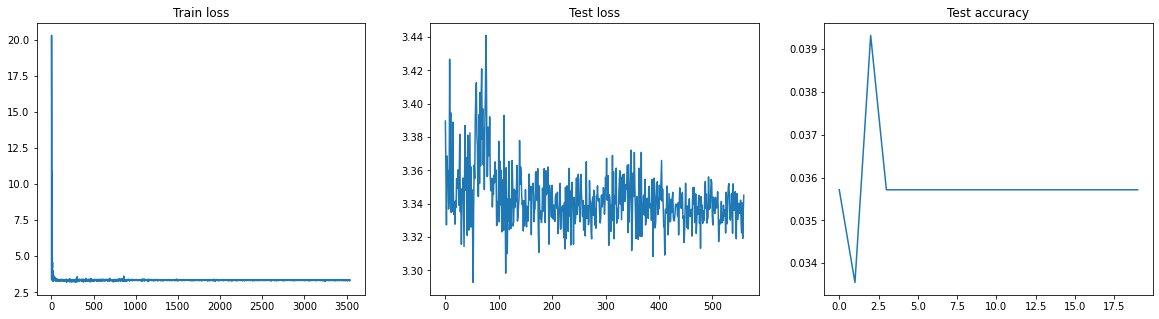

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (20,5))

ax[0].plot(train_loss)
ax[0].set_title("Train loss")
ax[1].plot(test_loss)
ax[1].set_title("Test loss")
ax[2].plot(test_acc)
ax[2].set_title("Test accuracy")

## Summary

* The first network is small, hence fast and performs reasonably good, having accuracy around 81% (random guessing has accuracy of 3.6%)

* Slightly bigger network, with one more dense layer and dropout performs the same as the previous one

* Data augmentation doesn't help. This might be because the network requires longer training and *maybe* should be bigger

* The biggest network I've tried was too big to fit into the memory. More precisely, it run out of the memory when trying to predict outputs. It has 4 conv layers, but with a lot more filters than the previous networks, and 4 dense layers. So I left only one dense layers and reduce bathsize from 256 to 64. But the network stopped learning after few epochs.